In [1]:
import os                                               #os interface library 
import requests                                         #HTTP requests library
import pandas as pd                                     #panda library
from dotenv import load_dotenv                          #dotenv library to read keys and secrect key for api
import alpaca_trade_api as trade_api                    #Alpaca library
from MCForecastTools import MCSimulation                #Monta Carlos simulation apis
import json                                             #JSON library ro work with JSON objects
from datetime import date                               #Data-Time library
import numpy as np                                      #Numpy library
from ipywidgets import *                                #Interactive Widgets library
from matplotlib import pyplot as plt                    #Map plot library

#set the backend of matplotlib to the 'inline' backend 
%matplotlib inline 


Bad key savefig.frameon in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probab

In [2]:
# Load .env enviroment variables
load_dotenv()

True

In [3]:
#Set up the alpaca trading API to retrieve data
def setting_api():
    alpaca_api_key=os.getenv("ALPACA_API_KEY")                                    #Set the Alpaca Key
    alpaca_secret_key=os.getenv("ALPACA_SECRET_KEY")                              #Set the Alpaca secret key
    alpaca = trade_api.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')  #Set the REST api with URL and keys
    return alpaca                                                                 #Return the Alpaca API object


#Function for retrieving data relative to tickers/portfolio
def portfolio_data(tickers):
    today = date.today() + pd.DateOffset(years=-5)                                #Set Start date 5 years back from now                    
    today = pd.Timestamp(today, tz="America/New_York").isoformat()                #convert to ISO datetime format
    timeframe ='1Day'                                                             #Set to retrive day trade data
    portfolio =alpaca.get_bars(tickers,timeframe,start=today,adjustment='raw').df #Get the trading info based on the ticker
    portfolio.index = portfolio.index.date                                        #Set index key to date column 
    return portfolio                                                              #Return the extracted value


#function for retrieving data related to benchmark:
def bench_mark(symbol):
    bench_mark = portfolio_data(symbol)                                           #Get benchmark data from Alpaca API for giventicker
    symbol = bench_mark[['close']].rename(columns = {'close': symbol})            #Rename column from 'close' to ticker name
    return symbol                                                                 #Return the extracted value


#function to seperate the required data :
def format_data(symbol):
    ticker =portfolio[portfolio["symbol"]==symbol].drop("symbol", axis=1)         #Extract ticker based on given symbol value
    closing_price = ticker[['close']]                                             #Extract close price only for that ticker
    closing_price = closing_price.rename(columns={'close' : symbol})              #Rename the column to "close"
    return closing_price                                                          #Return the extracted value


#function for calculating cuumulative returns:
def cumulative_returns(data):
    data_returns = data.pct_change()                                             #Calculate % change for given df - data
    data_cumulative = (1 + data_returns).cumprod()                               #compute the cumulative product on %change
    return data_cumulative                                                       #Return the extracted value

# function for equally weghting stocks:
def equal_weights(data):
    weights = []                                                                #Set list variable -> weights
    for i in range(0, len(portfolio.columns)):                                  #Cal weights for each element in -> data
        w = 1 / len(portfolio.columns)
        weights.append(w)                                                       #Append calculated value to weights list
    return weights                                                              #Return the composed list


#Run the MC Simulation
def MC_simulation(Years):
    global simulation_ew
    if Years > 0:
        simulation_ew = MCSimulation(                                           #run the MC simulation
                portfolio,
                weights=equal_weights(portfolio),
                num_simulation=1000,
                num_trading_days=252*Years)
        simulation_ew.calc_cumulative_return()                                  #Calculate the cumulative return
        display(simulation_ew.simulated_return)                                 #Display simulated return
        display(simulation_ew.plot_simulation())                                #Plot the simulated return

        
#calculating confidenace level based on MC simulation
def confidence_level(Investment):
    """
    MC Simulation must be ran before executing this function
    """
    global summary_stats
    Investment = Investment.replace('$','')                                     #Remove $
    Investment = Investment.replace(',','')                                     #Remove ','
    Investment = int(Investment)                                                #Convert the value to int
    summary_stats = simulation_ew.summarize_cumulative_return()                 # summary statistics from the MC simulation results
    initial_investment = Investment                                             # Set initial investment

    # Using lower & upper CI to calculate the `95%` confidence level for chosen investment
    ci_lower = round(summary_stats[8] * initial_investment, 2)
    ci_upper = round(summary_stats[9] * initial_investment, 2)

    # Print results
    print(f"There is a 95% chance that an initial investment of ${initial_investment:,.02f} in the portfolio"
          f" over a year will end within in the range of"
          f" ${ci_lower:,.02f} and ${ci_upper:,.02f}")


In [4]:
alpaca = setting_api()                                    #Set the Alpaca API
tickers = ['APD', 'APH', 'RACE', 'TEL', 'IFF', 'GLW']     #Set tickers
portfolio = portfolio_data(tickers)                       #Rtv ticker values using Alpca API
portfolio.head()                                          #Show the retrieved value

,open,high,low,close,volume,trade_count,vwap,symbol
2017-04-17,134.78,135.8950,134.42,135.86,1092375,11416,135.497295,APD
2017-04-18,135.04,136.0200,134.72,135.27,701020,10116,135.259170,APD
2017-04-19,135.73,136.0399,134.78,134.96,577819,7170,135.166924,APD
2017-04-20,135.62,137.3400,135.20,136.90,985329,10779,136.676759,APD
2017-04-21,136.87,137.6600,136.82,137.30,1121329,9645,137.275887,APD


In [5]:
#Extract and format each ticker from df Portfolio
apd =format_data('APD')
aph =format_data('APH')
race=format_data('RACE')
tel=format_data('TEL')
iff=format_data('IFF')
glw=format_data('GLW')
glw.head()                    #Display apd df

,GLW
2017-04-17,26.54
2017-04-18,26.89
2017-04-19,26.86
2017-04-20,27.11
2017-04-21,27.02


In [6]:
spy = bench_mark('SPY')     #Get the benchmark ticker - S&P 500
spy.head()                  #View the retrieved dataframe

,SPY
2017-04-17,234.57
2017-04-18,233.87
2017-04-19,233.44
2017-04-20,235.34
2017-04-21,234.59


In [7]:
#Concatinate all the tickers into one dataframe
portfolio = pd.concat([apd, aph, race, tel, iff, glw],axis =1)
portfolio.head()       #View the concatinated df

,APD,APH,RACE,TEL,IFF,GLW
2017-04-17,135.86,69.53,71.32,72.77,133.02,26.54
2017-04-18,135.27,69.96,70.59,73.08,134.07,26.89
2017-04-19,134.96,70.12,71.26,73.18,134.53,26.86
2017-04-20,136.90,70.82,71.40,74.12,135.80,27.11
2017-04-21,137.30,70.47,70.82,73.61,136.12,27.02


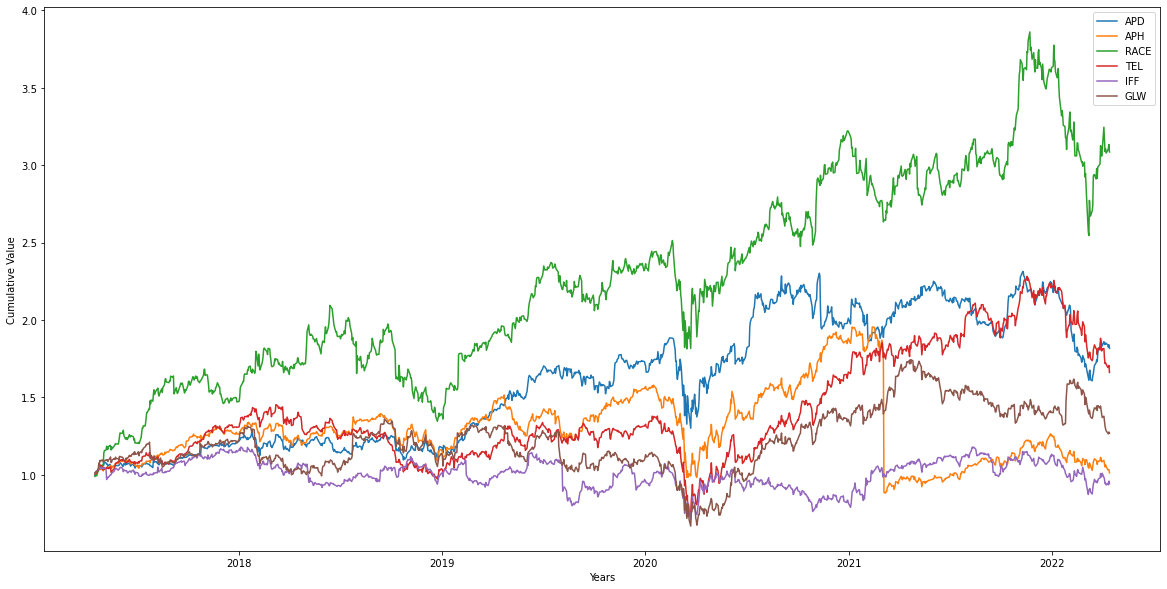

In [8]:
portfolio_cumulative = cumulative_returns(portfolio)       #Calculate cumulative returns for stock portfolio
portfolio_cumulative.dropna(inplace=True)                  #Drop all na values
portfolio_cumulative.plot(figsize = (20,10), kind="line", ylabel='Cumulative Value', xlabel='Years')  #Plot line graph on portfolio
plt.savefig('Images/Portfolio Cumulative.png', bbox_inches='tight')    #Save the graph

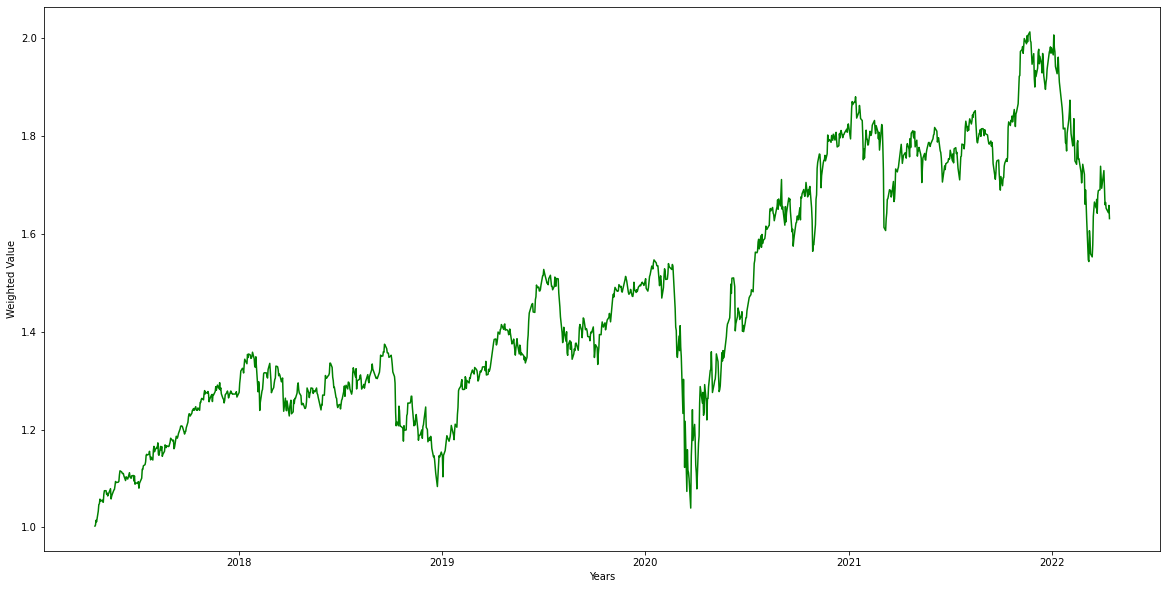

In [9]:
weights = equal_weights(portfolio)                                #Calculate the equal weighted value for each ticker
portfolio_price_action = portfolio_cumulative.dot(weights)        #Get the cumulative product by weights for each tickers

#Plot line graph
portfolio_price_action.plot(figsize = (20,10), kind="line", ylabel='Weighted Value', xlabel='Years', color='g')  
plt.savefig('Images/portfolio_price_action', bbox_inches='tight')    #Save the graph

In [10]:
spy_cumulative = cumulative_returns(spy)                                                             #Get cumulative return ffor benchmark
comparison = pd.concat([portfolio_price_action,spy_cumulative],axis = 1 ,join = 'inner').dropna()    #Concat both df
comparison = comparison.rename(columns = {0:'E.W Portfolio'})                                        #Give a column name

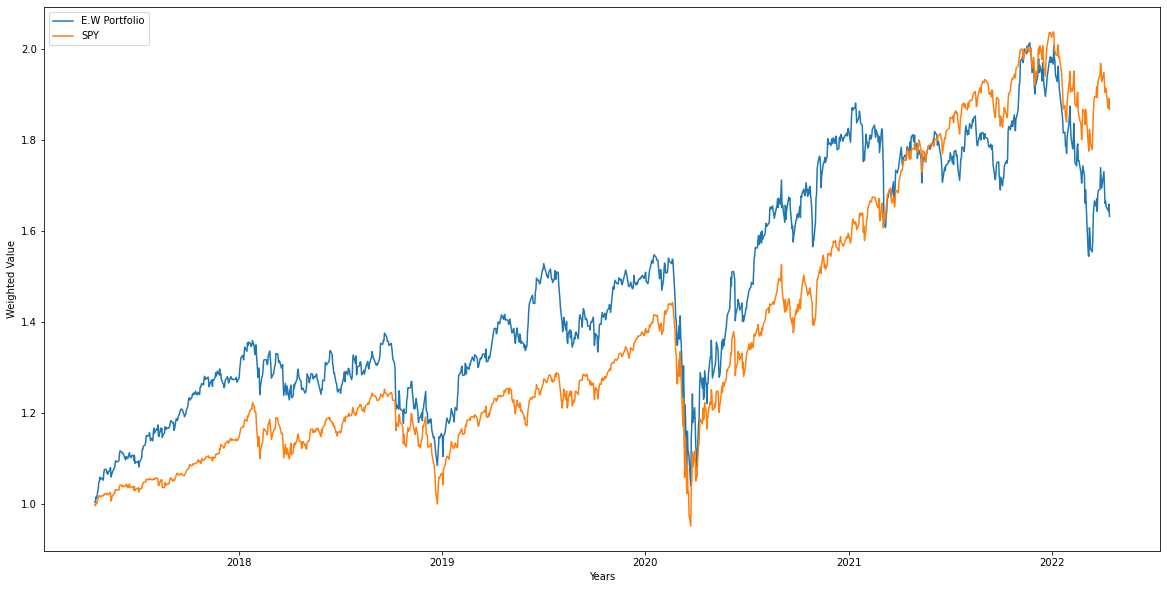

In [11]:
#Plot the comparison data
comparison.plot(figsize = (20,10), kind="line", ylabel='Weighted Value', xlabel='Years')
plt.savefig('Images/Comparison Plot.png', bbox_inches='tight')    #Save the graph

In [12]:
#Rename column to close since Mc requires column name "close"
apd = apd.rename(columns={'APD' : 'close'})
aph = aph.rename(columns={'APH' : 'close'})
race = race.rename(columns={'RACE' : 'close'})
tel = tel.rename(columns={'TEL' : 'close'})
iff = iff.rename(columns={'IFF' : 'close'})
glw = glw.rename(columns={'GLW' : 'close'})
portfolio = pd.concat([apd,aph,race,tel,iff,glw],axis =1,keys = ['APD','APH','RACE','TEL','IFF','GLW'])

#Alow user to chioose the number of trading days for MC simulation 
heading = widgets.Label('Choose your trading years')   #Set the widget heading
display(heading)                                       #Display the heading
interactive(MC_simulation, Years=([1, 3, 5]))          #Show the dropdown box


Label(value='Choose your trading years')

interactive(children=(Dropdown(description='Years', options=(1, 3, 5), value=1), Output()), _dom_classes=('wid…

In [15]:
#Allow user to choose their initial investment amount to calculate predited amount
#at 95% confidence level
heading = widgets.Label('Choose your initial investment')
display(heading)
interactive(confidence_level, Investment=['$5,000', '$10,000', '$15,000'], value=None)

Label(value='Choose your initial investment')

interactive(children=(Dropdown(description='Investment', options=('$5,000', '$10,000', '$15,000'), value='$5,0…

In [16]:
# Calculate volatility based on the MC stats
volatility = round(summary_stats[2] * np.sqrt(252) )        #Calculate the volatility
volatility                                                  #Display the values

2

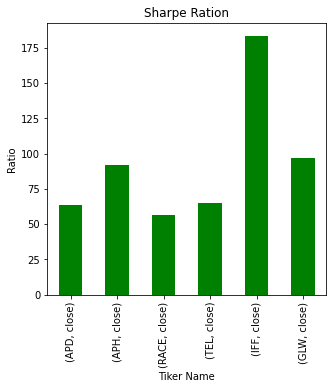

In [17]:
# Annualized Sharpe Ratios
annualized_sharpe_ratio = (portfolio.mean()* 252) / (portfolio.std() * np.sqrt(252))

# Visualize the sharpe ratios as a bar plot
annualized_sharpe_ratio.plot(kind = "bar", title = "Sharpe Ration", figsize = (5,5), ylabel="Ratio", xlabel="Tiker Name", color='g')
plt.savefig('Images/Sharpe Ratio.png', bbox_inches='tight')                   #Save the graph